<a href="https://colab.research.google.com/github/Zakuta/D-QRL/blob/main/working_code_QRL_cp_vmap_batched_over_envs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install equinox
# !pip install tensorcircuit
# !pip install -U qiskit
# !pip install tensorcircuit
# !pip install cirq
# !pip install openfermion
# !pip install gymnax
# !pip install brax
# !pip install distrax
# !pip install flax

In [8]:
import jax
from jax import config

config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

import jax.numpy as jnp
DTYPE=jnp.float64

import chex
import numpy as np
import optax
from flax import struct
from functools import partial
import tensorcircuit as tc

import equinox as eqx
import types
from jaxtyping import Array, PRNGKeyArray
from typing import Union, Sequence, List, NamedTuple, Optional, Tuple, Any, Literal, TypeVar
import jax.tree_util as jtu
import gymnax
import distrax
from gymnax.environments import environment, spaces
from brax import envs
from brax.envs.wrappers.training import EpisodeWrapper, AutoResetWrapper

K = tc.set_backend("jax")

In [9]:
# shamelessly taken from purejaxrl: https://github.com/luchris429/purejaxrl/blob/main/purejaxrl/wrappers.py

class GymnaxWrapper(object):
    """Base class for Gymnax wrappers."""

    def __init__(self, env):
        self._env = env

    # provide proxy access to regular attributes of wrapped object
    def __getattr__(self, name):
        return getattr(self._env, name)


class FlattenObservationWrapper(GymnaxWrapper):
    """Flatten the observations of the environment."""

    def __init__(self, env: environment.Environment):
        super().__init__(env)

    def observation_space(self, params) -> spaces.Box:
        assert isinstance(
            self._env.observation_space(params), spaces.Box
        ), "Only Box spaces are supported for now."
        return spaces.Box(
            low=self._env.observation_space(params).low,
            high=self._env.observation_space(params).high,
            shape=(np.prod(self._env.observation_space(params).shape),),
            dtype=self._env.observation_space(params).dtype,
        )

    @partial(jax.jit, static_argnums=(0,))
    def reset(
        self, key: chex.PRNGKey, params: Optional[environment.EnvParams] = None
    ) -> Tuple[chex.Array, environment.EnvState]:
        obs, state = self._env.reset(key, params)
        obs = jnp.reshape(obs, (-1,))
        return obs, state

    @partial(jax.jit, static_argnums=(0,))
    def step(
        self,
        key: chex.PRNGKey,
        state: environment.EnvState,
        action: Union[int, float],
        params: Optional[environment.EnvParams] = None,
    ) -> Tuple[chex.Array, environment.EnvState, float, bool, dict]:
        obs, state, reward, done, info = self._env.step(key, state, action, params)
        obs = jnp.reshape(obs, (-1,))
        return obs, state, reward, done, info


@struct.dataclass
class LogEnvState:
    env_state: environment.EnvState
    episode_returns: float
    episode_lengths: int
    returned_episode_returns: float
    returned_episode_lengths: int
    timestep: int


class LogWrapper(GymnaxWrapper):
    """Log the episode returns and lengths."""

    def __init__(self, env: environment.Environment):
        super().__init__(env)

    @partial(jax.jit, static_argnums=(0,))
    def reset(
        self, key: chex.PRNGKey, params: Optional[environment.EnvParams] = None
    ) -> Tuple[chex.Array, environment.EnvState]:
        obs, env_state = self._env.reset(key, params)
        state = LogEnvState(env_state, 0, 0, 0, 0, 0)
        return obs, state

    @partial(jax.jit, static_argnums=(0,))
    def step(
        self,
        key: chex.PRNGKey,
        state: environment.EnvState,
        action: Union[int, float],
        params: Optional[environment.EnvParams] = None,
    ) -> Tuple[chex.Array, environment.EnvState, float, bool, dict]:
        obs, env_state, reward, done, info = self._env.step(
            key, state.env_state, action, params
        )
        new_episode_return = state.episode_returns + reward
        new_episode_length = state.episode_lengths + 1
        state = LogEnvState(
            env_state=env_state,
            episode_returns=new_episode_return * (1 - done),
            episode_lengths=new_episode_length * (1 - done),
            returned_episode_returns=state.returned_episode_returns * (1 - done)
            + new_episode_return * done,
            returned_episode_lengths=state.returned_episode_lengths * (1 - done)
            + new_episode_length * done,
            timestep=state.timestep + 1,
        )
        info["returned_episode_returns"] = state.returned_episode_returns
        info["returned_episode_lengths"] = state.returned_episode_lengths
        info["timestep"] = state.timestep
        info["returned_episode"] = done
        return obs, state, reward, done, info

In [9]:
# def reuploading_circuit(n_qubits, n_layers, rot_params, input_params, X):
#   circuit = tc.Circuit(n_qubits)

#   for l in range(n_layers):
#     # variational part
#     for qubit_idx in range(n_qubits):
#       circuit.rx(qubit_idx, theta=rot_params[l, qubit_idx, 0])
#       circuit.ry(qubit_idx, theta=rot_params[l, qubit_idx, 1])
#       circuit.rz(qubit_idx, theta=rot_params[l, qubit_idx, 2])

#     # entangling part
#     for qubit_idx in range(n_qubits - 1):
#       circuit.cnot(qubit_idx, qubit_idx + 1)
#     if n_qubits != 2:
#       circuit.cnot(n_qubits - 1, 0)

#     # encoding part
#     for qubit_idx in range(n_qubits):
#       input = X[qubit_idx] * input_params[l, qubit_idx]
#       # print(input)
#       circuit.rx(qubit_idx, theta=input)

#   # last variational part
#   for qubit_idx in range(n_qubits):
#     circuit.rx(qubit_idx, theta=rot_params[n_layers, qubit_idx, 0])
#     circuit.ry(qubit_idx, theta=rot_params[n_layers, qubit_idx, 1])
#     circuit.rz(qubit_idx, theta=rot_params[n_layers, qubit_idx, 2])

#   return circuit


# class QuantumActor(eqx.Module):
#   theta: jax.Array # trainable
#   lmbd: jax.Array # trainable
#   w: jax.Array # trainable
#   n_qubits: int = eqx.field(static=True)
#   n_layers: int = eqx.field(static=True)
#   beta: float = eqx.field(static=True)
#   n_actions: Sequence[int] = eqx.field(static=True)
#   # key: int

#   def __init__(self, n_qubits, n_layers, beta, n_actions, params: Optional, key = 42):

#     key = jax.random.PRNGKey(key)
#     key, _key = jax.random.split(key, num=2)

#     if params is None:
#       # rotation_params
#       self.theta = params['thetas']
#       # input encoding params
#       self.lmbd = params['lmbds']
#       # observable weights
#       self.w = params['ws']
#     else:
#       self.theta = jax.random.uniform(key=key, shape=(n_layers + 1, n_qubits, 3),
#                                     minval=0.0, maxval=np.pi, dtype=DTYPE)
#       self.lmbd = jnp.ones(shape=(n_layers, n_qubits), dtype=DTYPE)
#       self.w = jnp.array([[(-1.) ** i for i in range(n_actions)]])


#     self.n_qubits = n_qubits
#     self.n_layers = n_layers
#     self.beta = beta
#     self.n_actions = n_actions

#   def quantum_policy_circuit(self, inputs):

#     # this can be any PQC of the user's choice. hence, I made the decision to make a separate function within this class
#     circuit = reuploading_circuit(self.n_qubits, self.n_layers, self.theta, self.lmbd, inputs)

#     return K.real(circuit.expectation_ps(z=np.arange(self.n_qubits)))

#   def alternating(self, inputs):
#     return jnp.matmul(inputs, self.w)

#   def get_params(self):
#     return {'thetas': self.theta, 'lmbds': self.lmbd, 'ws': self.w}

#   def __call__(self, x):

#     pqc = self.quantum_policy_circuit(x)
#     alt = self.alternating(jnp.array([pqc], dtype=DTYPE))
#     actor_mean = eqx.nn.Lambda(lambda x: x * self.beta)(alt)
#     policy = distrax.Softmax(actor_mean)

#     return policy


# class TrainState(eqx.Module):
#   model: eqx.Module
#   optimizer: optax.GradientTransformation = eqx.field(static=True)
#   opt_state: optax.OptState

#   def __init__(self, model, optimizer, opt_state):
#     self.model = model
#     self.optimizer = optimizer
#     self.opt_state = opt_state

#   def apply_updates_to_model(self, new_params):
#     # this function is specific and works for this example only. one can think of
#     # generalizing it to work for updating any given attribute/params of the model.

#     model_new = eqx.tree_at(where=lambda model: model.theta, pytree=self.model, replace=new_params['thetas'])
#     model_new = eqx.tree_at(where=lambda model: model.lmbd, pytree=model_new, replace=new_params['lmbds'])
#     model_new = eqx.tree_at(where=lambda model: model.w, pytree=model_new, replace=new_params['ws'])

#     return model_new

#   def apply_gradients(self, params, grads):
#     grads = {'thetas': grads.theta, 'lmbds': grads.lmbd, 'ws': grads.w}
#     updates, opt_state = self.optimizer.update(grads, self.opt_state, params)
#     new_params = optax.apply_updates(params, updates)
#     model_new = self.apply_updates_to_model(new_params)
#     # model = eqx.apply_updates(self.model, updates)
#     new_train_state = self.__class__(model=model_new, optimizer=self.optimizer, opt_state=opt_state)
#     return new_train_state

# class Transition(NamedTuple):
#   done: jnp.ndarray
#   action: jnp.ndarray
#   reward: jnp.ndarray
#   log_prob: jnp.ndarray
#   obs: jnp.ndarray
#   # params: jnp.ndarray
#   info: jnp.ndarray

In [24]:
def reuploading_circuit(n_qubits, n_layers, rot_params, input_params, X):
  circuit = tc.Circuit(n_qubits)

  for l in range(n_layers):
    # variational part
    for qubit_idx in range(n_qubits):
      circuit.rx(qubit_idx, theta=rot_params[l, qubit_idx, 0])
      circuit.ry(qubit_idx, theta=rot_params[l, qubit_idx, 1])
      circuit.rz(qubit_idx, theta=rot_params[l, qubit_idx, 2])

    # entangling part
    for qubit_idx in range(n_qubits - 1):
      circuit.cnot(qubit_idx, qubit_idx + 1)
    if n_qubits != 2:
      circuit.cnot(n_qubits - 1, 0)

    # encoding part
    for qubit_idx in range(n_qubits):
      input = X[qubit_idx] * input_params[l, qubit_idx]
      # print(input)
      circuit.rx(qubit_idx, theta=input)

  # last variational part
  for qubit_idx in range(n_qubits):
    circuit.rx(qubit_idx, theta=rot_params[n_layers, qubit_idx, 0])
    circuit.ry(qubit_idx, theta=rot_params[n_layers, qubit_idx, 1])
    circuit.rz(qubit_idx, theta=rot_params[n_layers, qubit_idx, 2])

  return circuit


class QuantumActor(eqx.Module):
  theta: jax.Array # trainable
  lmbd: jax.Array # trainable
  w: jax.Array # trainable
  n_qubits: int = eqx.field(static=True)
  n_layers: int = eqx.field(static=True)
  beta: float = eqx.field(static=True)
  n_actions: Sequence[int] = eqx.field(static=True)
  # key: int

  def __init__(self, n_qubits, n_layers, beta, n_actions, key):

    self.theta = jax.random.uniform(key=key, shape=(n_layers + 1, n_qubits, 3),
                                  minval=0.0, maxval=np.pi, dtype=DTYPE)
    self.lmbd = jnp.ones(shape=(n_layers, n_qubits), dtype=DTYPE)
    self.w = jnp.array([[(-1.) ** i for i in range(n_actions)]])


    self.n_qubits = n_qubits
    self.n_layers = n_layers
    self.beta = beta
    self.n_actions = n_actions

  def quantum_policy_circuit(self, inputs):

    # this can be any PQC of the user's choice. hence, I made the decision to make a separate function within this class
    circuit = reuploading_circuit(self.n_qubits, self.n_layers, self.theta, self.lmbd, inputs)

    return K.real(circuit.expectation_ps(z=np.arange(self.n_qubits)))

  def alternating(self, inputs):
    return jnp.matmul(inputs, self.w)

  def get_params(self):
    return {'thetas': self.theta, 'lmbds': self.lmbd, 'ws': self.w}

  def __call__(self, x):

    pqc = self.quantum_policy_circuit(x)
    alt = self.alternating(jnp.array([pqc], dtype=DTYPE))
    actor_mean = eqx.nn.Lambda(lambda x: x * self.beta)(alt)
    policy = distrax.Softmax(actor_mean)

    return policy


class TrainState(eqx.Module):
  model: eqx.Module
  optimizer: optax.GradientTransformation = eqx.field(static=True)
  opt_state: optax.OptState

  def __init__(self, model, optimizer, opt_state):
    self.model = model
    self.optimizer = optimizer
    self.opt_state = opt_state

  def apply_updates_to_model(self, new_params):
    # this function is specific and works for this example only. one can think of
    # generalizing it to work for updating any given attribute/params of the model.

    model_new = eqx.tree_at(where=lambda model: model.theta, pytree=self.model, replace=new_params['thetas'])
    model_new = eqx.tree_at(where=lambda model: model.lmbd, pytree=model_new, replace=new_params['lmbds'])
    model_new = eqx.tree_at(where=lambda model: model.w, pytree=model_new, replace=new_params['ws'])

    return model_new

  def apply_gradients(self, params, grads):
    grads = {'thetas': grads.theta, 'lmbds': grads.lmbd, 'ws': grads.w}
    updates, opt_state = self.optimizer.update(grads, self.opt_state, params)
    new_params = optax.apply_updates(params, updates)
    model_new = self.apply_updates_to_model(new_params)
    # model = eqx.apply_updates(self.model, updates)
    new_train_state = self.__class__(model=model_new, optimizer=self.optimizer, opt_state=opt_state)
    return new_train_state

class Transition(NamedTuple):
  done: jnp.ndarray
  action: jnp.ndarray
  reward: jnp.ndarray
  log_prob: jnp.ndarray
  obs: jnp.ndarray
  # params: jnp.ndarray
  info: jnp.ndarray


@eqx.filter_jit
def train_cp(conf):
  env, env_params = gymnax.make(conf['env_name'])
  env = FlattenObservationWrapper(env)
  env = LogWrapper(env)

  n_actions = env.action_space(env_params).n

  def train(rng):
    actor = QuantumActor(
        n_qubits=conf['n_qubits'], n_layers=conf['n_layers'],
        beta=conf['beta'], n_actions=n_actions, key=rng)

    state_bounds = jnp.array([2.4, 2.5, 0.21, 2.5], dtype=DTYPE)

    def map_nested_fn(fn):
      '''Recursively apply `fn` to the key-value pairs of a nested dict'''
      def map_fn(nested_dict):
        return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v))
                for k, v in nested_dict.items()}
      return map_fn

    label_fn = map_nested_fn(lambda k, _: k)
    optim = optax.multi_transform({'thetas': optax.amsgrad(conf['lr_theta']),
                                  'lmbds': optax.amsgrad(conf['lr_lmbd']),
                                  'ws': optax.amsgrad(conf['lr_w'])},
                              label_fn)

    opt_state = optim.init(actor.get_params())

    train_state = TrainState(model=actor, optimizer=optim, opt_state=opt_state)

    rng, _rng = jax.random.split(rng)
    reset_rng = jax.random.split(_rng, conf['n_envs'])
    obs, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

    def apply_actor_env(network, state, rng, state_bounds):
      norm_state = state.reshape(-1) / state_bounds
      policy = network(norm_state)
      action = policy.sample(seed=rng)
      log_prob = policy.log_prob(action)
      return action, log_prob, norm_state

    def update_episode(runner_state, ununsed):
      def env_step(runner_state, ununsed):
        train_state, env_state, last_obs, rng = runner_state

        rng, rng_net = jax.random.split(rng)
        actor = train_state.model
        action, log_prob, norm_last_obs = jax.vmap(
            apply_actor_env, in_axes=(None, 0, None, None)
            )(actor, last_obs, rng_net, state_bounds)

        rng, _rng = jax.random.split(rng)
        rng_step = jax.random.split(_rng, conf['n_envs'])
        obs, env_state, reward, done, info = jax.vmap(
            env.step, in_axes=(0, 0, 0, None)
            )(rng_step, env_state, action, env_params)

        transition = Transition(
            done, action, reward, log_prob, norm_last_obs, info)

        runner_state = (train_state, env_state, obs, rng)

        return runner_state, transition

      runner_state, traj_batch = jax.lax.scan(env_step, runner_state, None, conf['n_steps'])

      train_state, env_state, last_obs, rng = runner_state

      def calculate_returns(traj_batch):
        def _compute_discounted_sum(carry, transition):
          rewards_to_go = carry
          reward = transition.reward
          rewards_to_go = reward + conf['gamma'] * rewards_to_go
          # baseline = 0
          return rewards_to_go, rewards_to_go

        init_carry = jnp.zeros_like(0, dtype=DTYPE)

        def _compute_single_returns(traj):
          _, returns = jax.lax.scan(
              _compute_discounted_sum,
              init_carry,
              traj,
              reverse=True,
          )
          return returns

        returns = jax.vmap(_compute_single_returns)(traj_batch)

        mean_returns = jnp.mean(returns, axis=1, keepdims=True)
        std_returns = jnp.std(returns, axis=1, keepdims=True)
        normalized_returns = (returns - mean_returns) / (std_returns + conf['eps'])

        return normalized_returns

      returns = calculate_returns(traj_batch)

      @eqx.filter_value_and_grad
      def reinforce_update(actor, batch_info):

        obs, returns, action = batch_info

        def compute_log_prob(obs_i, action_i):
          policy = actor(obs_i)
          log_prob_i = policy.log_prob(action_i)
          return log_prob_i

        log_probs = jax.vmap(compute_log_prob)(obs, action)
        loss = -jnp.mean(log_probs * returns) / conf['n_steps']

        return loss

      obs = traj_batch.obs
      action = traj_batch.action
      batch = (obs, returns, action)
      # batch_size = conf['n_steps'] * conf['n_envs']
      print(action.shape)
      print(returns.shape)
      batch_size = obs.shape[0] * obs.shape[1]
      assert batch_size == action.shape[0] * action.shape[1]
      # concatenating everything
      batch = jax.tree_util.tree_map(
          lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
          )
      print(batch[0].shape)
      loss, grads = reinforce_update(train_state.model, batch)
      train_state = train_state.apply_gradients(train_state.model.get_params(), grads)

      update_state = (train_state, traj_batch, returns, rng)

      train_state = update_state[0]
      metric = traj_batch.info
      # metric = traj_batch
      rng = update_state[-1]

      # Debugging mode
      if conf['debug']:
        def callback(info):
          return_values = info['returned_episode_returns'][info['returned_episode']]
          timesteps = info['timestep'][info['returned_episode']]
          for t in range(len(timesteps)):
            print(f"global step={timesteps[t]}, episodic return={return_values[t]}")
        jax.debug.callback(callback, metric)

      runner_state = (train_state, env_state, last_obs, rng)

      return runner_state, metric

    rng, _rng = jax.random.split(rng)
    runner_state = (train_state, env_state, obs, _rng)
    runner_state, metric = jax.lax.scan(update_episode,
                                        runner_state,
                                        None,
                                        conf['max_episodes'] // conf['n_steps'])

    return {'runner_state': runner_state, 'metrics': metric}

  return train


# conf = {'n_layers': 5,
#         'n_qubits': 4,
#         'beta': 1.0,
#         'n_envs': 4,
#         'total_timesteps': 125000,
#         'n_steps': 10,
#         'gamma': 0.99,
#         'n_minibatches': 4,
#         'update_epochs': 50000,
#         'debug': False,
#         'env_name': 'CartPole-v1',
#         'lr_theta': 0.01,
#         'lr_lmbd': 0.1,
#         'lr_w': 0.1,
#         # 'rng': 100,
#         'eps': 1e-8,
#         'max_episodes': 20000}

# rng = jax.random.PRNGKey(42)
# train_jit = jax.jit(train_cp(conf))
# out = train_jit(rng)
# rngs = jax.random.split(rng, 50)
# train_vjit = jax.vmap(train_cp(conf))
# outs = train_vjit(rngs)


In [29]:
conf = {'n_layers': 5,
        'n_qubits': 4,
        'beta': 1.0,
        'n_envs': 10,
        'n_steps': 10,
        'gamma': 1,
        'debug': False,
        'env_name': 'CartPole-v1',
        'lr_theta': 0.01,
        'lr_lmbd': 0.1,
        'lr_w': 0.1,
        'eps': 1e-8,
        'max_episodes': 10000}

# out = train_cp(conf)(jax.random.PRNGKey(42))
rng = jax.random.PRNGKey(42)
rngs = jax.random.split(rng, 50)
train_vjit = jax.vmap(train_cp(conf))
outs = train_vjit(rngs)

(10, 10)
(10, 10)
(100, 4)
(10, 10)
(10, 10)
(100, 4)


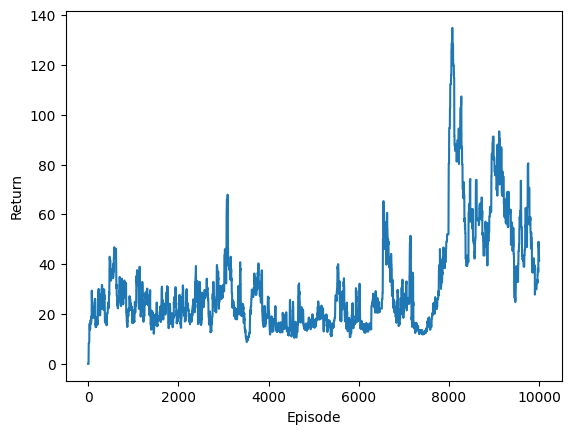

In [28]:
import matplotlib.pyplot as plt
plt.plot(out['metrics']['returned_episode_returns'].mean(-1).reshape(-1))
plt.xlabel("Episode")
plt.ylabel("Return")
plt.show()

In [14]:

# with jax.checking_leaks():
#     # Your code here
#     out = train_cp(conf)(jax.random.PRNGKey(42))
# out = train_cp(conf)(jax.random.PRNGKey(42))

<ipython-input-10-e51e6e995e6f>:11: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  params = {'thetas': jax.random.uniform(
<ipython-input-10-e51e6e995e6f>:15: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  'lmbds': jnp.ones(shape=(conf['n_layers'],
<ipython-input-10-e51e6e995e6f>:18: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_

global step=32, episodic return=32.0
global step=57, episodic return=25.0
global step=76, episodic return=19.0
global step=117, episodic return=41.0
global step=217, episodic return=100.0
global step=311, episodic return=94.0
global step=395, episodic return=84.0
global step=512, episodic return=117.0
global step=561, episodic return=49.0
global step=677, episodic return=116.0
global step=779, episodic return=102.0
global step=822, episodic return=43.0
global step=850, episodic return=28.0
global step=870, episodic return=20.0
global step=917, episodic return=47.0
global step=1010, episodic return=93.0
global step=1203, episodic return=193.0
global step=1254, episodic return=51.0
global step=1318, episodic return=64.0
global step=1407, episodic return=89.0
global step=1907, episodic return=500.0
global step=1943, episodic return=36.0
global step=1981, episodic return=38.0
global step=2057, episodic return=76.0
global step=2168, episodic return=111.0
global step=2213, episodic return=45

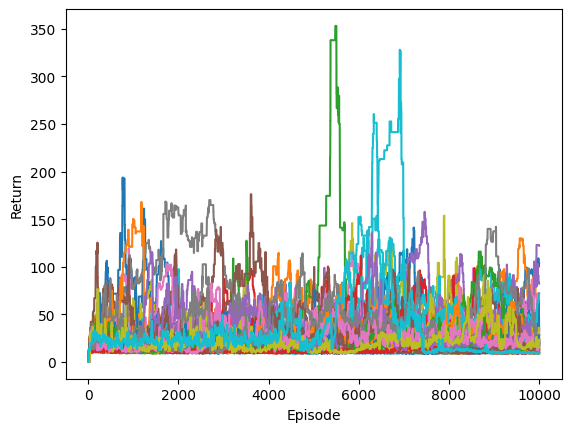

In [30]:
import matplotlib.pyplot as plt
for i in range(50):
  plt.plot(outs['metrics']['returned_episode_returns'][i].mean(-1).reshape(-1))
plt.xlabel("Episode")
plt.ylabel("Return")
plt.show()

In [38]:
type(outs['runner_state'][0].model.get_params())

dict

In [16]:
out['runner_state'][0].model.get_params()

{'thetas': Array([[[ 1.565861  ,  2.1200445 ,  0.4481497 ],
         [ 0.22830968,  2.5902557 ,  2.524495  ],
         [ 3.0214925 ,  0.81842935,  2.8251534 ],
         [ 0.2570623 ,  1.7158911 , -0.08308051]],
 
        [[ 1.0606378 ,  1.8226256 ,  2.1108472 ],
         [ 3.1958911 ,  3.1265016 ,  1.3786011 ],
         [ 2.0359268 ,  1.3253636 ,  2.4516432 ],
         [ 1.8849581 ,  0.4751683 ,  1.3561558 ]],
 
        [[ 2.1840096 ,  1.9487733 ,  1.9424497 ],
         [ 1.6786586 ,  0.6193537 ,  1.7370325 ],
         [ 1.4270581 ,  2.939099  ,  0.82407516],
         [ 0.36700878,  2.8985736 ,  3.072952  ]],
 
        [[ 1.1996425 , -0.10907994,  2.0991728 ],
         [ 1.7716439 ,  0.0913705 ,  2.9296274 ],
         [ 1.6949264 ,  1.4600992 ,  0.73301625],
         [ 2.6678145 ,  0.47320873,  1.6722952 ]],
 
        [[ 1.4491268 ,  1.3773788 ,  0.21831371],
         [ 0.00604603,  2.8121288 ,  0.50831556],
         [ 0.9960863 ,  2.4113224 ,  1.5959505 ],
         [ 1.5670866 ,  2.78

In [40]:
outs['runner_state'][0].model.get_params()['ws']

Array([[[ 3.07315666, -3.07315666]],

       [[-4.03457022,  4.03457022]],

       [[ 2.21377314, -2.21377314]],

       [[ 4.55148361, -4.55148361]],

       [[ 3.22563082, -3.22563082]],

       [[-2.3016937 ,  2.3016937 ]],

       [[ 0.81746269, -0.81746269]],

       [[ 4.03379042, -4.03379042]],

       [[ 2.99824739, -2.99824739]],

       [[ 0.03311249, -0.03311249]],

       [[ 5.95818105, -5.95818105]],

       [[ 2.91174893, -2.91174893]],

       [[ 0.78827977, -0.78827977]],

       [[-1.72369032,  1.72369032]],

       [[ 3.22558783, -3.22558783]],

       [[ 4.08977523, -4.08977523]],

       [[ 0.85230065, -0.85230065]],

       [[ 0.90081095, -0.90081095]],

       [[ 4.85900675, -4.85900675]],

       [[ 3.99558486, -3.99558486]],

       [[ 4.00819734, -4.00819734]],

       [[ 1.23726879, -1.23726879]],

       [[ 1.45831931, -1.45831931]],

       [[ 3.50351353, -3.50351353]],

       [[-3.27640548,  3.27640548]],

       [[-2.47027857,  2.47027857]],

       [[-4.

In [37]:
a.reshape(-1)

array([1, 2, 3, 4, 5, 6, 7, 8])

In [1]:
a

NameError: name 'a' is not defined

In [4]:
import jax.numpy as jnp

a = jnp.array([[1,2,3,4], [5,6,7,8]])

In [7]:
a.mean(axis=1)

Array([2.5, 6.5], dtype=float32)

In [13]:
a

Array([[1, 5],
       [2, 6],
       [3, 7],
       [4, 8]], dtype=int32)

In [8]:
a / jnp.array([1,2,3,4])

Array([[1.       , 1.       , 1.       , 1.       ],
       [5.       , 3.       , 2.3333333, 2.       ]], dtype=float32)

In [ ]:
# import jax.numpy as jnp

# # Example batch size
# batch_size = 3

# actor = QuantumActor(
#     n_qubits=conf['n_qubits'], n_layers=conf['n_layers'],
#     beta=conf['beta'], n_actions=n_actions, key=rng)

# @jax.vmap
# def apply_actor(network, state, rng):
#   policy = network(state.reshape(-1) / jnp.array([1,2,3,4]))
#   action = policy.sample(seed=rng)
#   log_prob = policy.log_prob(action)
#   return action, log_prob

# # Dummy inputs
# dummy_state = jnp.zeros((batch_size, 4))  # Assuming input_dim is defined

# # Dummy RNG
# dummy_rng = jax.random.PRNGKey(0)

# # Apply the actor function
# actions, log_probs = apply_actor(network, dummy_state, dummy_rng)

# # Print the datatype of the return value
# print(type((actions, log_probs)))  # Output: <class 'tuple'>
# print(type(actions))  # Output: <class 'jax.interpreters.xla.DeviceArray'>
# print(type(log_probs))  # Output: <class 'jax.interpreters.xla.DeviceArray'>
